# Box control in satellite Formation Flying 

We are here interested in showing how *heyoka.py* event detection machine can be used in an innovative formulation of the box-control problem for formation flying satellites. This is the problem of controlling a Deputy satellite to remain within a predefined control box defined in the Local Horizontal Local Vertical frame of the Chief satellite.

To derive all equations we used and abused the [Vectrix notation from Hugues](https://vatankhahghadim.github.io/AER506/Notes/1%20-%20Fundamentals.pdf).

## Preliminaries
We consider the fundamental problem of satellite formation flying. A main satellite called Chief orbits some primary body (here the Earth). We consider two reference frames. $\mathcal F_i=\left[\hat{\mathbf e}_i, \hat{\mathbf e}_j, \hat{\mathbf e}_k \right]$ is the inertial frame where the motion of both satellites will be described, while $\mathcal F_L=\left[\hat{\mathbf e}_r, \hat{\mathbf e}_\theta, \hat{\mathbf e}_h \right]$ is the Local Horizontal Local Vertical frame referred to the Chief satellite. Its definition in terms of the Chief satellite position $\overrightarrow{\mathbf r}$ and velocity $\overrightarrow{\mathbf v}$ is:

$$
\left\{
\begin{array}{ll}
\hat{\mathbf e}_r &= \frac{\overrightarrow{\mathbf r}}{r} \\
\hat{\mathbf e}_\theta &= \hat{\mathbf e}_h \times \hat{\mathbf e}_r\\ 
\hat{\mathbf e}_h &= \frac{\overrightarrow{\mathbf r} \times {\overrightarrow{\mathbf v}}} {\vert\overrightarrow{\mathbf r} \times {\overrightarrow{\mathbf v}}\vert}
\end{array}
\right.
$$

We indicate with capital letters $X,Y,Z$ the components of the satellite position vector in the frame $\mathcal F_i$, we introduce the quantities $r = \vert\overrightarrow{\mathbf r}\vert$, $r = \vert\overrightarrow{\mathbf h}\vert$ and $\sigma = \overrightarrow{\mathbf r}\cdot \overrightarrow{\mathbf v}$ and write the rotation matrix $\mathbf C_{Li} = \mathcal F_L^T \cdot \mathcal F_i$ for the LHLV frame:

\begin{equation}
    \label{eq:rotation}
\mathbf C_{Li} = 
\frac{1}{hr}\left[
\begin{array}{ccc}
hX & hY & hZ \\
r^2\dot X - \sigma X & r^2\dot Y - \sigma Y & r^2\dot Z - \sigma Z \\
r(Y\dot Z - Z\dot Y) & r(Z\dot X - X\dot Z) & r(X\dot Y - Y\dot X) \\
\end{array}
\right]
\end{equation}

which allows to find the $\mathcal F_i$ components of a vector $\mathbf v_i$ from its $\mathcal F_L$ components as $\mathbf v_i = \mathbf C_{Li} \mathbf v_L$. The angular velocity of the LHLV frame is:

$$
\overrightarrow{\boldsymbol \omega} = \mathcal F_L \boldsymbol \omega_L = 
\left[\hat{\mathbf e}_r, \hat{\mathbf e}_\theta, \hat{\mathbf e}_h \right]
\left[
\begin{array}{l}
\omega_x\\
\omega_y\\
\omega_z\\
\end{array}
\right] = 
\left[\hat{\mathbf e}_r, \hat{\mathbf e}_\theta, \hat{\mathbf e}_h \right]
\left[
\begin{array}{l}
\frac rh  f_h\\
0 \\
\frac{h}{r^2}
\end{array}
\right]
$$

where $f_h$ is the perturbative acceleration acting on the satellite along the $\hat{\mathbf e}_h$ direction.

## The Equations of Motion
We consider the dynamics of both the Chief and the Deputy expressed in terms of their position and velocity in $\mathcal F_i$ and subject to the J2 term only (the expression of additional terms for the Earth gravitational potential can be found [here]((https://space.stackexchange.com/questions/22266/j2-long-period-perturbations-in-the-inclination)):

$$
\left\{
\begin{array}{ll}
\ddot X_C &= -\frac \mu{r_C^3}X_C + c\frac 1{r_C^5} \left(5\frac{Z_C^2}{r_C^2}-1 \right) X_C\\
\ddot Y_C &= -\frac \mu{r_C^3}Y_C + c\frac 1{r_C^5} \left(5\frac{Z_C^2}{r_C^2}-1 \right) Y_C\\ 
\ddot Z_C &= -\frac \mu{r_C^3}Z_C + c\frac 1{r_C^5} \left(5\frac{Z_C^2}{r_C^2}-1 \right) Z_C - 2c\frac 1{r_C^5} Z_C\\
\ddot X_D &= -\frac \mu{r_D^3}X_D + c\frac 1{r_D^5} \left(5\frac{Z_D^2}{r_D^2}-1 \right) X_D\\
\ddot Y_D &= -\frac \mu{r_D^3}Y_D + c\frac 1{r_D^5} \left(5\frac{Z_D^2}{r_D^2}-1 \right) Y_D\\ 
\ddot Z_D &= -\frac \mu{r_D^3}Z_D + c\frac 1{r_D^5} \left(5\frac{Z_D^2}{r_D^2}-1 \right) Z_D - 2c\frac 1{r_D^5} Z_D\\
\end{array}
\right.
$$

## The Initial conditions
The initial conditions for the Chief satellite can be generic and are given in the $\mathcal F_i$ frame. The initial conditions for the Deputy, instead, are given in the $\mathcal F_L$ frame,. This simple fact couples the system breaking the symmetry of the equations of motion written above. Expressing the relative position and velocity as absolute and viceversa requires the use of $\mathbf C_{Li}$, and most importantly of $\omega_L$ which is, in turn, affected by the perturbative accelerations acting on the Chief. The following transformations hold:

\begin{equation}
\begin{array}{ll}
\left[
\begin{array}{l}
 X_D\\
 Y_D \\
 Z_D
\end{array}
\right] &= 
\left[
\begin{array}{l}
 X_C\\
 Y_C \\
 Z_C
\end{array}
\right]+
\mathbf C_{Li}^T \left[
\begin{array}{l}
 x\\
 y \\
 z
\end{array}
\right]
\\
\left[
\begin{array}{l}
\dot X_D\\
\dot Y_D \\
\dot Z_D
\end{array}
\right] &= 
\left[
\begin{array}{l}
\dot X_C\\
\dot Y_C \\
\dot Z_C
\end{array}
\right]+
\mathbf C_{Li}^T \left[
\begin{array}{l}
 \dot x\\
 \dot y \\
 \dot z
\end{array}
\right]
+ \mathbf C_{Li}^T \boldsymbol w_L^\times \left[\begin{array}{l}
 x\\
 y \\
 z
\end{array}
\right]
\end{array}
\end{equation}

where we have indicated with small letters $x,y,z$ the components of the relative position vector of the Deputy.

We can now start to code this in *heyoka.py*, we will introduce later the control part of the problem.

In [1]:
# The usual main imports
import heyoka as hy
import numpy as np

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

We start writing down the Equation of Motion (EOM):

In [2]:
# The state (using km as unit length)
xC, yC, zC, vxC, vyC, vzC, xD, yD, zD, vxD, vyD, vzD, = hy.make_vars("xC", "yC", "zC", "vxC", "vyC", "vzC", "xD", "yD", "zD", "vxD", "vyD", "vzD")

# Parameters
mu = 398600.4418 #km^3/sec^2 
J2 = 1082.645E-6
Re = 6371 #km
c = 3./2. * J2*mu*Re**2

# Auxiliary variables
rC2 = xC**2+yC**2+zC**2
rD2 = xD**2+yD**2+zD**2

# EOM 
# Chief
dxC = vxC
dyC = vyC
dzC = vzC
dvxC = (- mu * xC/rC2 - c * xC / rC2**2 * (1 - 5*zC**2/rC2)) / hy.sqrt(rC2)
dvyC = (- mu * yC/rC2 - c * yC / rC2**2 * (1 - 5*zC**2/rC2)) / hy.sqrt(rC2)
dvzC = (- mu * zC/rC2 - c * zC / rC2**2 * (3 - 5*zC**2/rC2)) / hy.sqrt(rC2)

# Deputy
dxD = vxD
dyD = vyD
dzD = vzD
dvxD = (- mu * xD/rD2 - c * xD / rD2**2 * (1 - 5*zD**2/rD2)) / hy.sqrt(rD2)
dvyD = (- mu * yD/rD2 - c * yD / rD2**2 * (1 - 5*zD**2/rD2)) / hy.sqrt(rD2)
dvzD = (- mu * zD/rD2 - c * zD / rD2**2 * (3 - 5*zD**2/rD2)) / hy.sqrt(rD2)

# Equations
eqns = [(xC, dxC), (yC, dyC), (zC, dzC), (vxC, dvxC), (vyC, dvyC), (vzC, dvzC), (xD, dxD), (yD, dyD), (zD, dzD), (vxD, dvxD), (vyD, dvyD), (vzD, dvzD)]

And some helper functions allowing conversions between inertial and LHLV frames:

In [3]:
def compute_LHLV_rot(state, fh):
    """Computes the rotation matrix C from inertial to LHLV. i.e. v_{LHLV} = C v_{inertial} 
    and the angular velocity of the LHLV frame
    
    Args:
        state (1D np.array): the satellite state in the inertial frame
        fh (float): disturbance acting on the satellite along the i_h axis (aligned with angular momentum)

    Returns:
        np.matrix (3x3): the rotation matrix
        np.matrix (3x1): the angular velocity
    """
    # We dispatch to the correct implementation of sqrt according to the state type
    if type(state[0]) == type(xC):
        sqrt = hy.sqrt
        zero = hy.expression(0)
    else:
        sqrt = np.sqrt
        state_type = float
        zero = 0.
    # Rotation Matrix
    X, Y, Z, DX, DY, DZ = state
    r2 = X*X+Y*Y+Z*Z
    r = sqrt(r2)
    h2 = (Y*DZ-Z*DY)**2 + (Z*DX-X*DZ)**2 + (X*DY-Y*DX)**2
    h = sqrt(h2)
    sigma = X*DX+Y*DY+Z*DZ
    retval1 = np.matrix([[h*X, h*Y, h*Z], [r2*DX-sigma*X, r2*DY-sigma*Y, r2*DZ-sigma*Z], [r*(Y*DZ-Z*DY), r*(Z*DX-X*DZ), r*(X*DY-Y*DX)]]) / h / r
    
    # Angular velocity
    retval2 = np.matrix([[r/h*fh],[zero],[h/r2]])
    
    return retval1, retval2

def to_relative(stateC, stateD, fh):
    """Transforms the state of the Deputy to the LHLV frame attached to the Chief
    
    Args:
        stateC (1D np.array): the Chief state in the inertial frame 
        stateD (1D np.array): the Deputy state in the inertial frame
        fh (float): disturbance acting on the Chief satellite along the i_h axis (aligned with angular momentum)

    Returns:
        np.array, np.array: r,v in the LHLV frame
    """
    # We reshape the input state into column vectors and alike
    X, Y, Z, DX, DY, DZ = stateC
    XD, YD, ZD, DXD, DYD, DZD = stateD
    rC = np.matrix([[X],[Y],[Z]])
    rD = np.matrix([[XD],[YD],[ZD]])
    vC = np.matrix([[DX],[DY],[DZ]])
    vD = np.matrix([[DXD],[DYD],[DZD]])
    # We compute the LHLV rotation matrix and angular velocity
    C, omega = compute_LHLV_rot(stateC, fh)
    # We compute the relative state
    xD = C * (rD - rC)
    dxD = C * (vD - vC) - np.cross(omega.transpose(), xD.transpose()).transpose()
    return [xD[0,0], xD[1,0], xD[2,0], dxD[0,0], dxD[1,0], dxD[2,0]]
    
    
def to_absolute(stateC, stateD, fh):
    """Transforms the state of the Deputy to the inertial frame
    
    Args:
        stateC (1D np.array): the Chief state in the inertial frame 
        stateD (1D np.array): the Deputy state in the LHLV frame attached to the Chief
        fh (float): disturbance acting on the Chief satellite along the i_h axis (aligned with angular momentum)

    Returns:
        np.array, np.array: r,v in the LHLV frame
    """
    # We reshape the input state into column vectors and alike
    X, Y, Z, DX, DY, DZ = stateC
    x, y, z, dx, dy, dz = stateD
    rC = np.matrix([[X],[Y],[Z]])
    xD = np.matrix([[x],[y],[z]])
    vC = np.matrix([[DX],[DY],[DZ]])
    dxD = np.matrix([[dx],[dy],[dz]])
    # We compute the LHLV rotation matrix and angular velocity
    C, omega = compute_LHLV_rot(stateC, fh)
    C = C.transpose()
    # We compute the absolute state
    rD = rC + C * xD
    vD = vC + C * (dxD + np.cross(omega.transpose(), xD.transpose()).transpose())
    return [rD[0,0], rD[1,0], rD[2,0], vD[0,0], vD[1,0], vD[2,0]]

def J2_LHLV(state, c):
    """Computes the J2 perturbation in the LHLV frame
    
    Args:
        state (1D np.array): the state in the inertial frame 
        c (float): the constant 3/2 * J2 * mu * Re**2
        
    Returns:
        np.array: the resulting J2 perturbation in the LHLV frame
    """
    # We dispatch to the correct implementation of sqrt according to the state type
    if type(state[0]) == type(xC):
        sqrt = hy.sqrt
        state_type = object
    else:
        sqrt = np.sqrt
        state_type = float
        
    X, Y, Z, DX, DY, DZ = state
    r2 = X*X+Y*Y+Z*Z
    r = sqrt(r2)
    h2 = (Y*DZ-Z*DY)**2 + (Z*DX-X*DZ)**2 + (X*DY-Y*DX)**2
    h = sqrt(h2)
    sigma = X*DX+Y*DY+Z*DZ
    return np.array([c/r2**2*(3*Z/r2-1), -2*c/h/r2**3*Z*(r2*DZ-sigma*Z), 2*c/h/r2**2/r*Z*(X*DY-X*DX)], dtype = state_type)

## Testing the Adaptive Taylor Integration and plotting the trajectories
Lets visualize the solution of the numerical integration in the LHLV frame for the Deputy and in the inertial frame for the Chief.

We use, as reference orbit for the Chief, a circular orbit at 300km of altitude and an inclination of 70 degrees. The deputy is set to follow behind in the LHLV frame at a distance of 1km

In [4]:
# Chief Orbit
incl = 70/180*np.pi
h = 300
a = Re+h
# Deputy orbit
trailing = 1.
# Initial Conditions for the Chief
chief_ic = [a,0,0,0,np.sqrt(mu/a)*np.cos(incl),np.sqrt(mu/a)*np.sin(incl)]
# Initial Conditions for the Deputy (we start in the LHLV frame)
deputy_ic_r = [0, -trailing ,0, 0, 0, 0]
fh = J2_LHLV(chief_ic, c)[2]
# Initial Conditions for the Chief (in the inertial frame)
deputy_ic = to_absolute(chief_ic, deputy_ic_r, fh)


we are now able to instantiate the the Taylor integrator:

In [5]:
# The Taylor integrator
ta = hy.taylor_adaptive(eqns, chief_ic + deputy_ic)

and to perform the integration:

In [6]:
# As a test we propagate for 10 orbits
# Number of points in the time grid
N = 1500
t_grid = np.linspace(0, 20*np.pi*np.sqrt(a**3/mu), N)
# Propagate and return the state at the grid points
oc, _, _, _, res = ta.propagate_grid(t_grid)

Since we wrote the equation in the inertial frame we need to retreive the Deputy state in the LHL frame:

In [7]:
# We compute the results in the LHLV frame for the Deputy
deputy_rel = np.zeros((N,6))
for i, item in enumerate(res):
    fh = J2_LHLV(item[:6], c)[2]
    deputy_rel[i] = to_relative(item[:6], item[6:], fh)

We can finally plot the resulting orbit:

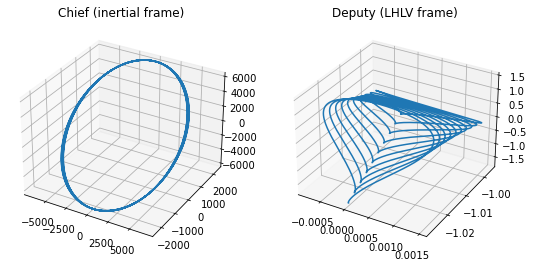

In [8]:
# And plot
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.plot3D(res[:, 0], res[:, 1], res[:, 2])
ax1.set_title("Chief (inertial frame)")
ax2.plot3D(deputy_rel[:, 0], deputy_rel[:, 1], deputy_rel[:, 2])
ax2.set_title("Deputy (LHLV frame)");


## Controlling the formation within a predefined box
Now that we have established the equation of motion, we can simulate a box-control strategy. 
In essence, we want to keep the Deputy within a box centered around its initial trailing position and of a predefined size.

To do so, each time the box border is reached, we will apply a $\Delta V$ flipping the relative velocity component along the corresponding axis, thus keeping the Deputy within the desired box.

First we write the callback which will flip the velocity and update the $\Delta V$ count.

In [9]:
# This callback flips the selected component (x = 3, y = 4, z = 5)
# of the relative velocity
def cb_flip_rel_component(ta, mr, component):
    global DV
    fh = J2_LHLV(ta.state[:6], c)[2]
    rel_state = to_relative(ta.state[:6], ta.state[6:], fh)
    # Changing the relevant component of the rel velocity
    rel_state[component] = -rel_state[component]
    new_abs_state = to_absolute(ta.state[:6], rel_state, fh)
    # Updating the absolute state
    ta.state[6:] = new_abs_state
    # Updating the DV count
    DV+=2*np.abs(rel_state[component])
    return True

We then define the various events triggering when the box boundary is reached. Since the control box is defined in the LHLV frame, we first need to compute the expressions of the relative state as a function of the absolute state.

In [10]:
# The size of the control box is 2 meters
box_size = 0.001

In [11]:
# We compute the expressions for the relative state as a function of the absolute state.
fh_sym = J2_LHLV([xC, yC, zC, dxC, dyC, dzC], c)
state_rel_sym = to_relative([xC, yC, zC, dxC, dyC, dzC],[xD, yD, zD, dxD, dyD, dzD], fh_sym)

# We define one event per cube side
ev_left = hy.t_event(state_rel_sym[0]  - box_size / 2, callback = lambda ta, mr: cb_flip_rel_component(ta, mr, 3), direction=hy.event_direction.positive)
ev_right = hy.t_event(state_rel_sym[0] + box_size / 2, callback = lambda ta, mr: cb_flip_rel_component(ta, mr, 3), direction=hy.event_direction.negative)
ev_front = hy.t_event(state_rel_sym[1] + trailing - box_size / 2, callback = lambda ta, mr: cb_flip_rel_component(ta, mr, 4), direction=hy.event_direction.positive)
ev_back = hy.t_event(state_rel_sym[1] + trailing + box_size / 2, callback = lambda ta, mr: cb_flip_rel_component(ta, mr, 4), direction=hy.event_direction.negative)
ev_top = hy.t_event(state_rel_sym[2] - box_size / 2, callback = lambda ta, mr: cb_flip_rel_component(ta, mr, 5), direction=hy.event_direction.positive)
ev_bottom = hy.t_event(state_rel_sym[2] + box_size / 2, callback = lambda ta, mr: cb_flip_rel_component(ta, mr, 5), direction=hy.event_direction.negative)

# We put all the control box events in a list as to pass them to the adaptive Taylor constructor.
box_events = [ev_top, ev_top, ev_front, ev_back, ev_left, ev_right]

/home/dario/miniconda3/envs/heyoka/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


Finally we can instantiate the Taylor integrator

In [12]:
ta = hy.taylor_adaptive(eqns, chief_ic + deputy_ic, t_events=box_events)

And propagate, taking care to reset first the $\Delta V$ count

In [13]:
# Resetting the DV counter
DV = 0
# We propagate 10 orbits as done above
N = 1500
t_grid = np.linspace(0, 20*np.pi*np.sqrt(a**3/mu), N)
oc, _, _, _, res = ta.propagate_grid(t_grid)
print("Total used DV is:", DV*1000, " m/s")

Total used DV is: 0.7030529513970147  m/s


We may now plot the trajectory as done above, first computing the LHLV Deputy position:

In [14]:
# We compute the results in the LHLV frame for the Deputy
deputy_rel = np.zeros((N,6))
for i, item in enumerate(res):
    fh = J2_LHLV(item[:6], c)[2]
    deputy_rel[i] = to_relative(item[:6], item[6:], fh)

Then plotting the trajectories:

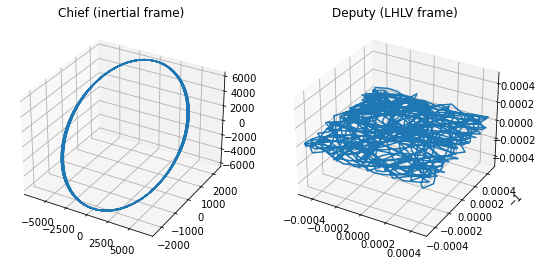

In [15]:
# And plot
limit = 1500
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.plot3D(res[:limit, 0], res[:limit, 1], res[:limit, 2])
ax1.set_title("Chief (inertial frame)")
ax2.plot3D(deputy_rel[:limit, 0], deputy_rel[:limit, 1], deputy_rel[:limit, 2])
ax2.set_title("Deputy (LHLV frame)")
ax2.set_xlim([-box_size/2, box_size/2])
ax2.set_ylim([-trailing-box_size/2, -trailing+box_size/2])
ax2.set_zlim([-box_size/2, box_size/2]);